In [45]:
# Import relevant libraries from environment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import sklearn.model_selection as curves
from time import time
import os
# print(os.listdir("../input"))
from IPython.display import display
# Any results you write to the current directory are saved as output.

import warnings
warnings.filterwarnings('ignore')

import itertools
from random import gauss, shuffle 

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [46]:
# Load all the dataset
tsal_inv_df = pd.read_excel("cleaned_sal_inv_data.xlsx")
test_df = pd.read_excel("test_data.xlsx")
nov_pred_df = pd.read_excel("nov_pred_df.xlsx")
dec_pred_df = pd.read_excel("dec_pred_df.xlsx")
jan_pred_df = pd.read_excel("jan_pred_df.xlsx")

In [47]:
# dropping certain columns to make all dataset consistent throughout
nov_pred_df.drop(["Unnamed: 0"], inplace=True, axis=1)
dec_pred_df.drop(["Unnamed: 0"], inplace=True, axis=1)
jan_pred_df.drop(["Unnamed: 0"], inplace=True, axis=1)
tsal_inv_df.drop(["Total inv", 'Product Title', 'UPC', 'Model No'], inplace=True, axis=1)
test_df.drop(['Product Title', 'UPC', 'Model No'], inplace=True, axis=1)

In [48]:
tsal_inv_df.sort_values(by="Date", inplace=True, ignore_index=True)
test_df.sort_values(by="Date", inplace=True, ignore_index=True)
nov_pred_df.sort_values(by="Date", inplace=True, ignore_index=True)
dec_pred_df.sort_values(by="Date", inplace=True, ignore_index=True)
jan_pred_df.sort_values(by="Date", inplace=True, ignore_index=True)

In [49]:
def time_feature (dataset):

    date_features = {
        "dayofweek": "dayofweek",
        "weekofyear": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "day": "day",
        "week": "week",
        "dayofyear": "dayofyear",
        "is_month_start": "is_month_start",
        "is_month_end": "is_month_end",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dataset.columns:
            dataset[date_feat_name] = dataset[date_feat_name].astype("int16")
        else:
            dataset[date_feat_name] = getattr(
                dataset["Date"].dt, date_feat_func
            ).astype("int16")
    return dataset

In [50]:
tsal_inv_df = time_feature(tsal_inv_df)
test_df = time_feature(test_df)
nov_pred_df = time_feature(nov_pred_df)
dec_pred_df = time_feature(dec_pred_df)
jan_pred_df = time_feature(jan_pred_df)

In [51]:
tsal_inv_df = tsal_inv_df[tsal_inv_df["Ordered Units"] > 0]
test_df = test_df[test_df["Ordered Units"] > 0]

In [52]:
tsal_inv_df = tsal_inv_df[tsal_inv_df["Ordered Units"] < 2500]
test_df = test_df[test_df["Ordered Units"] < 2500]

In [53]:
tsal_inv_df = tsal_inv_df[
    (tsal_inv_df["Date"] != "2022-04-13") & (tsal_inv_df["Ordered Units"] < 2000)
]

In [54]:
nov_pred_df.reset_index(inplace=True, drop=True)
dec_pred_df.reset_index(inplace=True, drop=True)
jan_pred_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
tsal_inv_df.reset_index(inplace=True, drop=True)

<AxesSubplot:xlabel='Date'>

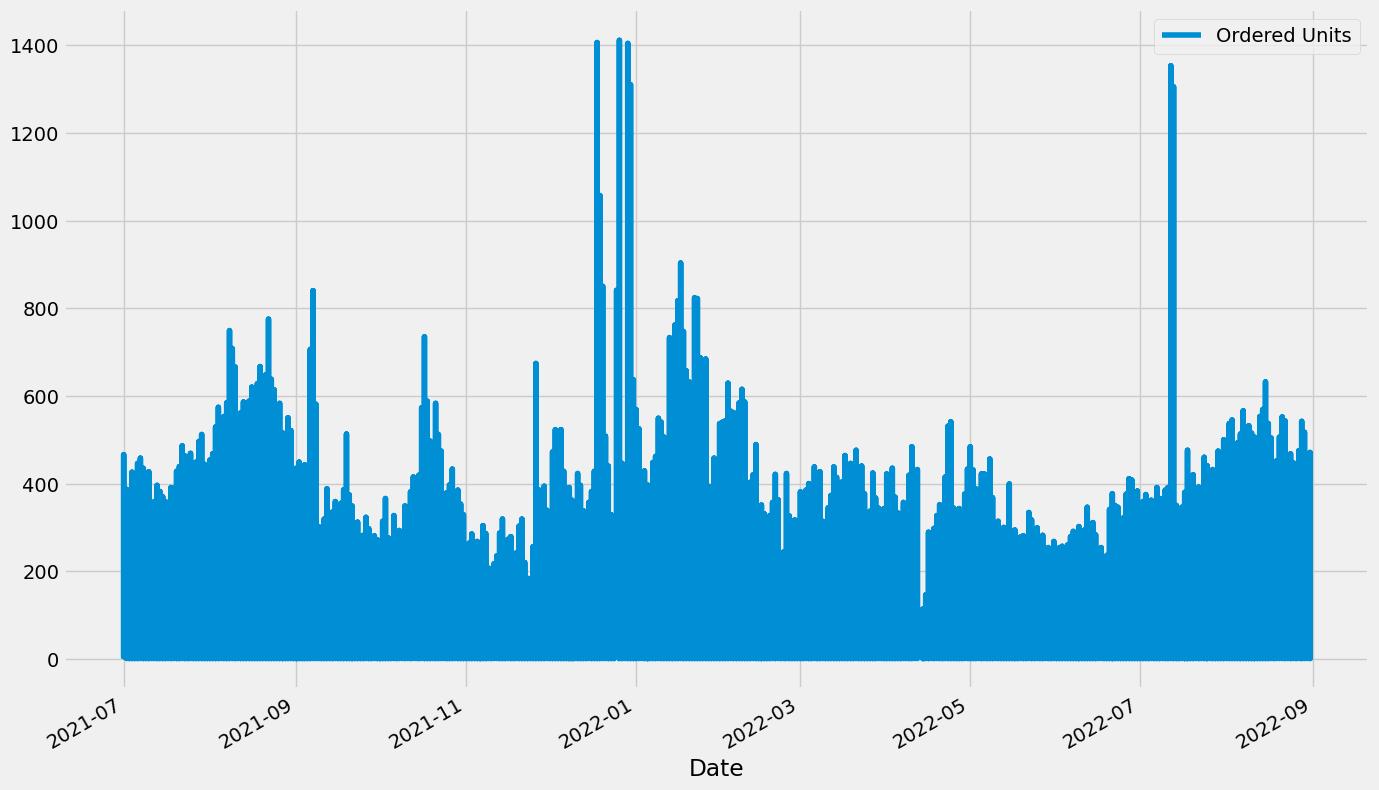

In [55]:
tsal_inv_df.plot(y="Ordered Units", x="Date", figsize=(15, 10))

<AxesSubplot:xlabel='Date'>

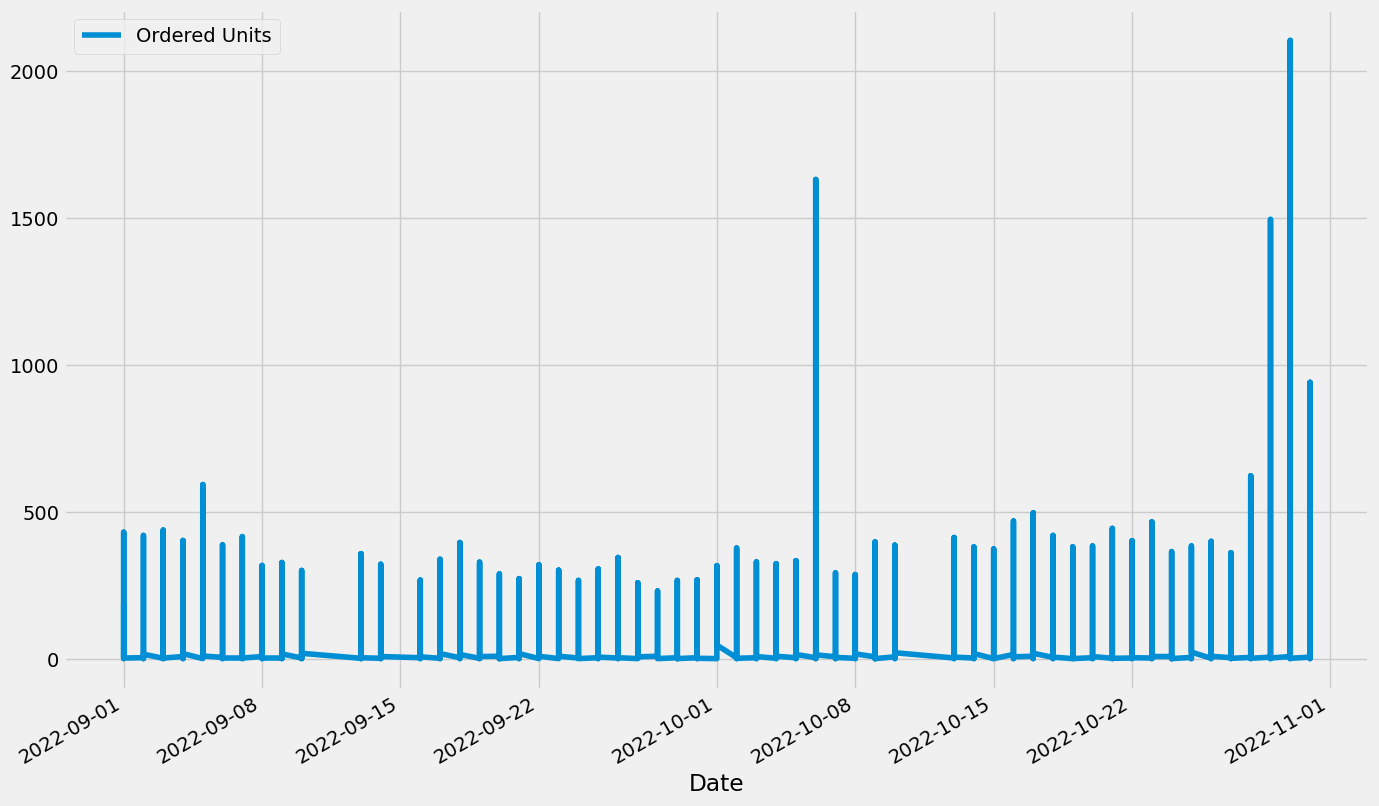

In [56]:
test_df.plot(y="Ordered Units", x="Date", figsize=(15, 10))

<AxesSubplot:xlabel='Date'>

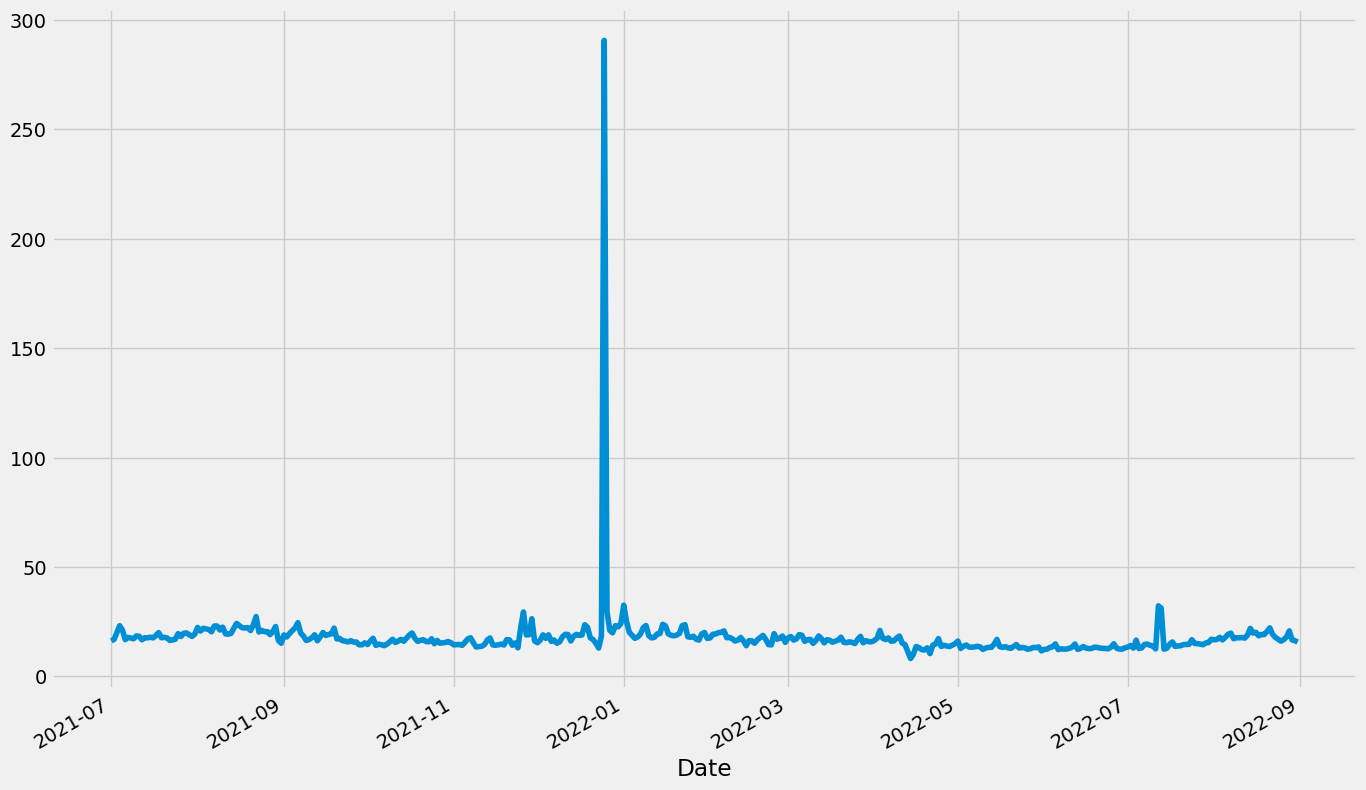

In [57]:
tsal_inv_df.groupby("Date")["Ordered Units"].mean().plot(
    y="Ordered Units", x="Date", figsize=(15, 10)
)

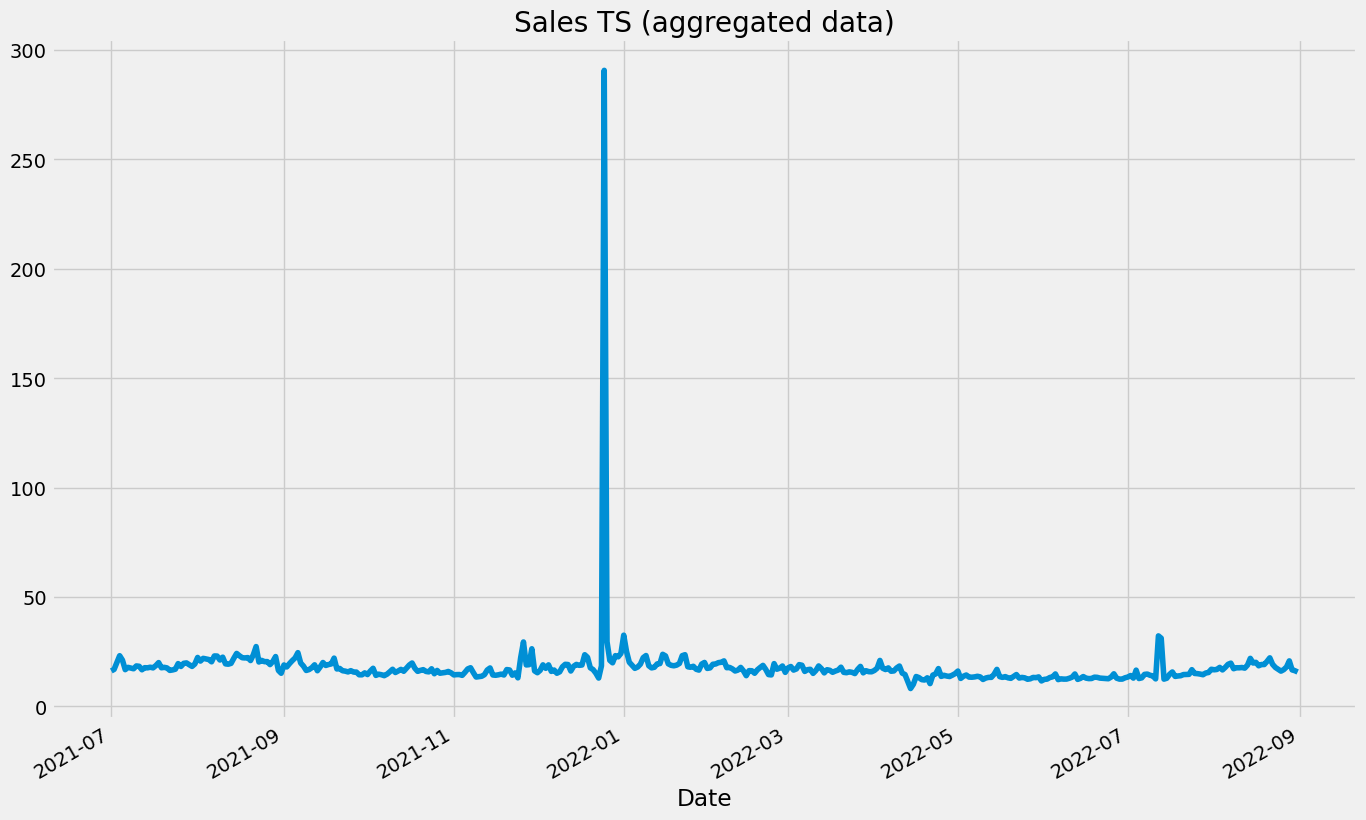

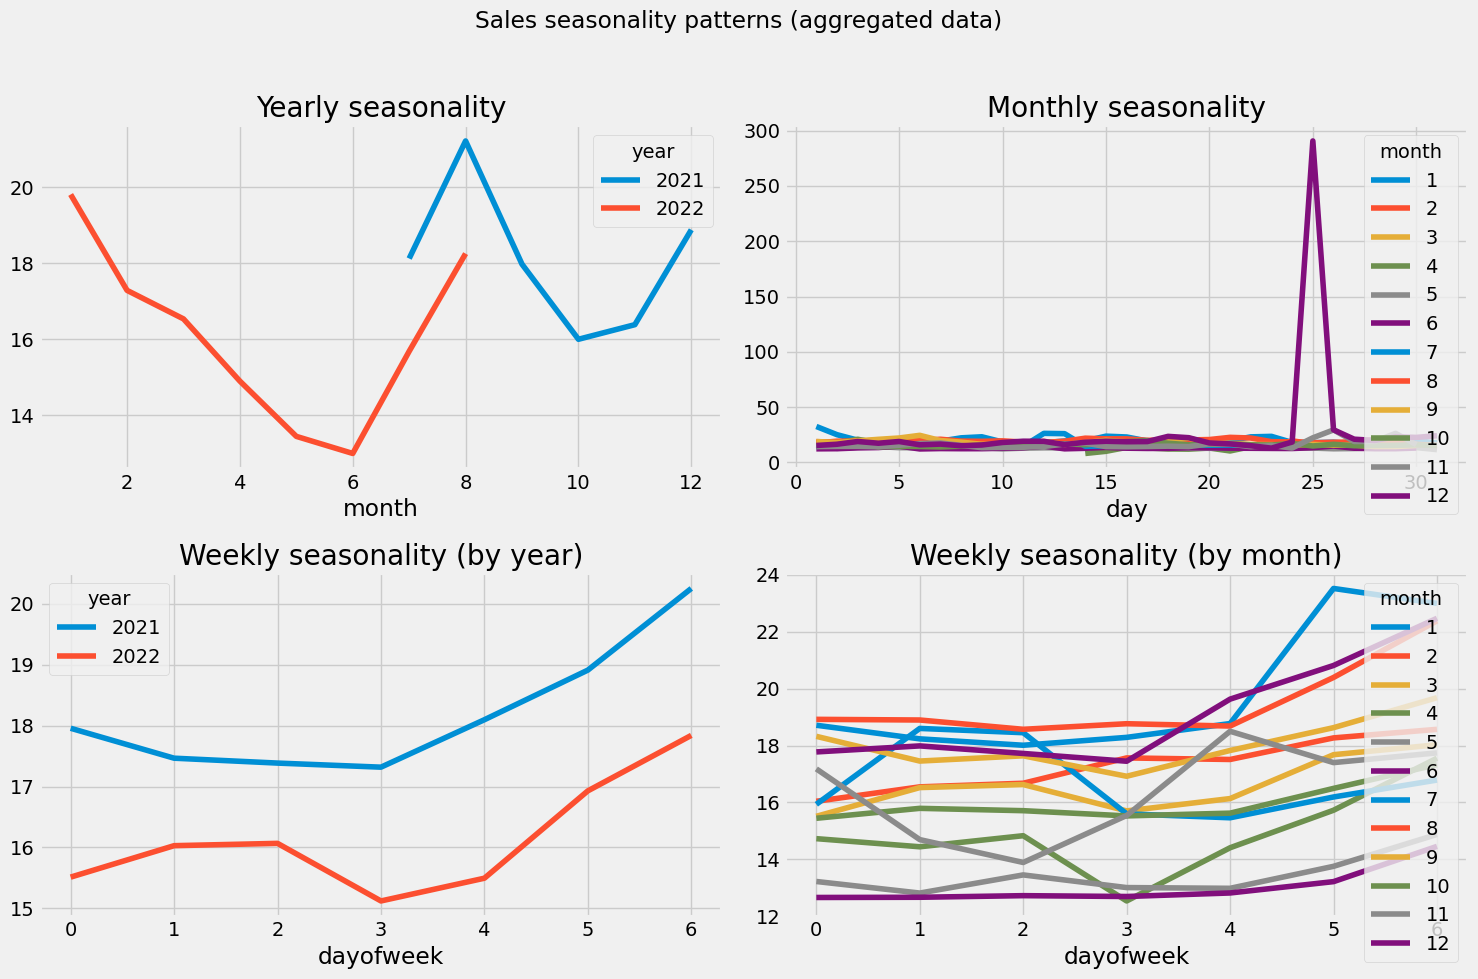

In [58]:
tsal_inv_df.groupby("Date").mean()["Ordered Units"].plot(
    figsize=(15, 10), title="Sales TS (aggregated data)"
)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
_ = pd.pivot_table(
    tsal_inv_df, values="Ordered Units", columns="year", index="month"
).plot(title="Yearly seasonality", ax=ax[0, 0])
_ = pd.pivot_table(
    tsal_inv_df, values="Ordered Units", columns="month", index="day"
).plot(title="Monthly seasonality", ax=ax[0, 1])
_ = pd.pivot_table(
    tsal_inv_df, values="Ordered Units", columns="year", index="dayofweek"
).plot(title="Weekly seasonality (by year)", ax=ax[1, 0])
_ = pd.pivot_table(
    tsal_inv_df, values="Ordered Units", columns="month", index="dayofweek"
).plot(title="Weekly seasonality (by month)", ax=ax[1, 1])
fig.suptitle("Sales seasonality patterns (aggregated data)")
fig.tight_layout(rect=[0, 0, 1, 0.96])

## Clean, encode and transform all the data features into data types which are interpretable by the machine learning model


In [59]:
from rdt import HyperTransformer

ht = HyperTransformer()
ht.detect_initial_config(data=tsal_inv_df)

Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "ASIN": "categorical",
        "Shipped COGS": "numerical",
        "Shipped COGS - % of Total": "numerical",
        "Shipped COGS - Prior Period": "numerical",
        "Shipped COGS - Last Year": "numerical",
        "Shipped Units": "numerical",
        "Shipped Units - % of Total": "numerical",
        "Shipped Units - Prior Period": "numerical",
        "Shipped Units - Last Year": "numerical",
        "Ordered Units": "numerical",
        "Ordered Units - % of Total": "numerical",
        "Ordered Units - Prior Period": "numerical",
        "Ordered Units - Last Year": "numerical",
        "Customer Returns": "numerical",
        "Free Replacements": "numerical",
        "Subcategory (Sales Rank)": "numerical",
        "Average Sales Price": "numerical",
        "Average Sales Price - Prior Period": "numerical",
        "Glance Views": "numerical",
        "Chang

In [60]:
# import and create new transformer objects
from rdt.transformers.categorical import FrequencyEncoder

categorical_transformer = FrequencyEncoder()

In [61]:
ht.update_transformers(
    column_name_to_transformer={
        "Subcategory (Sales Rank)": categorical_transformer,
    }
)

In [62]:
ht.remove_transformers(column_names=["Date"])

In [63]:
ht.get_config()

{
    "sdtypes": {
        "ASIN": "categorical",
        "Shipped COGS": "numerical",
        "Shipped COGS - % of Total": "numerical",
        "Shipped COGS - Prior Period": "numerical",
        "Shipped COGS - Last Year": "numerical",
        "Shipped Units": "numerical",
        "Shipped Units - % of Total": "numerical",
        "Shipped Units - Prior Period": "numerical",
        "Shipped Units - Last Year": "numerical",
        "Ordered Units": "numerical",
        "Ordered Units - % of Total": "numerical",
        "Ordered Units - Prior Period": "numerical",
        "Ordered Units - Last Year": "numerical",
        "Customer Returns": "numerical",
        "Free Replacements": "numerical",
        "Subcategory (Sales Rank)": "numerical",
        "Average Sales Price": "numerical",
        "Average Sales Price - Prior Period": "numerical",
        "Glance Views": "numerical",
        "Change in Glance View - Prior Period": "numerical",
        "Change in GV Last Year": "numerical"

In [64]:
ht.fit(tsal_inv_df)

In [65]:
transformed_train_df = ht.transform(tsal_inv_df)
transformed_test_df = ht.transform(test_df)
transformed_nov_pred_df = ht.transform(nov_pred_df)
transformed_dec_pred_df = ht.transform(dec_pred_df)
transformed_jan_pred_df = ht.transform(jan_pred_df)

In [66]:
def rename (dataset):

    dataset.rename(
        columns={
            "ASIN.value": "ASIN",
            "Shipped COGS.value": "Shipped_COGS",
            "Shipped COGS - % of Total.value": "Shipped_COGS_Total_Value",
            "Shipped COGS - Prior Period.value": "Shipped_COGS_Prior_Value",
            "Shipped COGS - Last Year.value": "Shipped_COGS_Last_Year",
            "Shipped Units.value": "Shipped_Units",
            "Shipped Units - % of Total.value": "Shipped_Units_Total_Value",
            "Shipped Units - Prior Period.value": "Shipped_Units_Prior_Value",
            "Shipped Units - Last Year.value": "Shipped_Units_Last_Year",
            "Ordered Units.value": "Ordered_Units",
            "Ordered Units - % of Total.value": "Ordered_Units_Total_Value",
            "Ordered Units - Prior Period.value": "Ordered_Units_Prior_Value",
            "Ordered Units - Last Year.value": "Ordered_Units_Last_Year",
            "Customer Returns.value": "Return",
            "Free Replacements.value": "Free_Replacement",
            "Subcategory (Sales Rank).value": "Sales_Rank",
            "Average Sales Price.value": "Average_Sales_Price",
            "Average Sales Price - Prior Period.value": "Average_Sales_Price_Prior_Value",
            "Glance Views.value": "Glance_Views",
            "Change in Glance View - Prior Period.value": "Glance_Views_Prior_Value",
            "Change in GV Last Year.value": "Glance_Views_Last_Year",
            "Conversion Rate.value": "Conversion_Rate",
            "Rep OOS.value": "Rep",
            "Rep OOS - % of Total.value": "Rep_Total_Value",
            "Rep OOS - Prior Period.value": "Rep_Prior_Value",
            "LBB (Price).value": "LBB",
            "AMZ Inv.value": "AMZ_inv",
            "Furinno Inv.value": "Furinno_inv",
            "dayofweek.value": "dayofweek",
            "weekofyear.value": "weekofyear",
            "month.value": "month",
            "quarter.value": "quarter",
            "year.value": "year",
            "day.value": "day",
            "week.value": "week",
            "dayofyear.value": "dayofyear",
            "is_month_start.value": "is_month_start",
            "is_month_end.value": "is_month_end",
        },
        inplace=True,
    )
    return dataset

In [67]:
transformed_train_df = rename(transformed_train_df)
transformed_test_df = rename(transformed_test_df)
transformed_nov_pred_df = rename(transformed_nov_pred_df)
transformed_dec_pred_df = rename(transformed_dec_pred_df)
transformed_jan_pred_df = rename(transformed_jan_pred_df)

In [68]:
ytrain = transformed_train_df["Ordered_Units"].copy()
ytest = transformed_test_df["Ordered_Units"].copy()

transformed_train_df.drop(["Date", "Ordered_Units"], axis=1, inplace=True)
transformed_test_df.drop(["Date", "Ordered_Units"], axis=1, inplace=True)
transformed_nov_pred_df.drop(["Date", "Ordered_Units"], axis=1, inplace=True)
transformed_dec_pred_df.drop(["Date", "Ordered_Units"], axis=1, inplace=True)
transformed_jan_pred_df.drop(["Date", "Ordered_Units"], axis=1, inplace=True)

## Lightgbm base model to test predominantly the performance of the data structures efficiency


In [69]:
params_p = {
    "learning_rate": 0.19483980858626945,
    "max_depth": 12,
    "bagging_fraction": 0.2,
    "feature_fraction": 0.4,
    "lambda_l2": 100,
    "lambda_l1": 75,
    "reg_alpha": 0.2458769456607237,
    "reg_lambda": 9.408720654061234,
    "min_gain_to_split": 0.0015099426408213823,
    "num_leaves": 2760,
    "min_data_in_leaf": 200,
}


m_lgb_p = lgb.LGBMRegressor(objective="poisson", **params_p)
m_lgb_p.fit(
    transformed_train_df,
    ytrain,
    eval_set=[(transformed_test_df, ytest)],
    eval_metric="rmse",
    early_stopping_rounds=100,
)

# Fit the model to the training data
m_lgb_p.fit(transformed_train_df, ytrain)

[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.2458769456607237 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0015099426408213823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0015099426408213823
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=9.408720654061234 will be ignored. Current value: lambda_l2=100
[1]	valid_0's rmse: 34.3097	valid_0's poisson: -33.6159
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 31.738	valid_0's poisson: -35.5901
[3]	valid_0's rmse: 29.2804	valid_0's poisson: -37.151
[4]	valid_0's

LGBMRegressor(bagging_fraction=0.2, feature_fraction=0.4, lambda_l1=75,
              lambda_l2=100, learning_rate=0.19483980858626945, max_depth=12,
              min_data_in_leaf=200, min_gain_to_split=0.0015099426408213823,
              num_leaves=2760, objective='poisson',
              reg_alpha=0.2458769456607237, reg_lambda=9.408720654061234)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

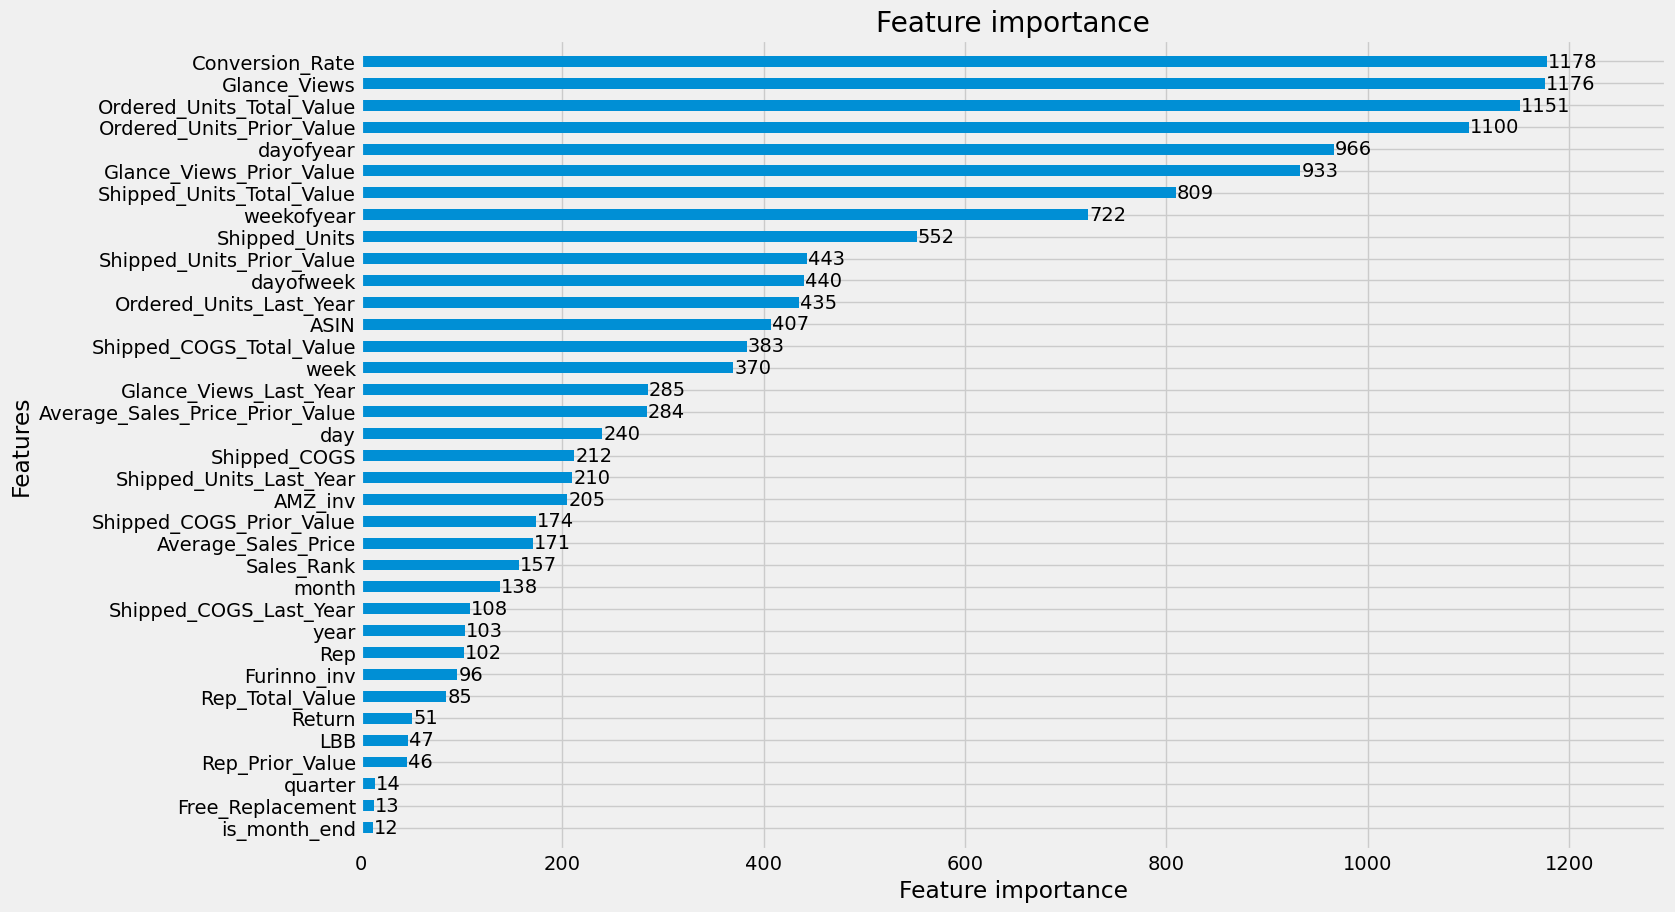

In [70]:
lgb.plot_importance(m_lgb_p, height=0.5, figsize=(15, 10))

## Cross-validation to double verify the model performance reliability and credibility


In [71]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(15, 10))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Ordered Unit Prediction")
    plt.xlabel("Time")
    plt.ylabel("Ordered Units")
    plt.legend()
    plt.show()

In [72]:
def my_rmse(x, y):
    return np.round(np.sqrt(mse(x, y)), 4)

In [73]:
# creating a function to test the MAPE of the model
def my_mape(actual, forecast):
    return np.round(np.mean(np.abs((actual - forecast) / actual)) * 100, 4)

In [74]:
print(my_mape(ytest, lgb_pred_p))

7.804


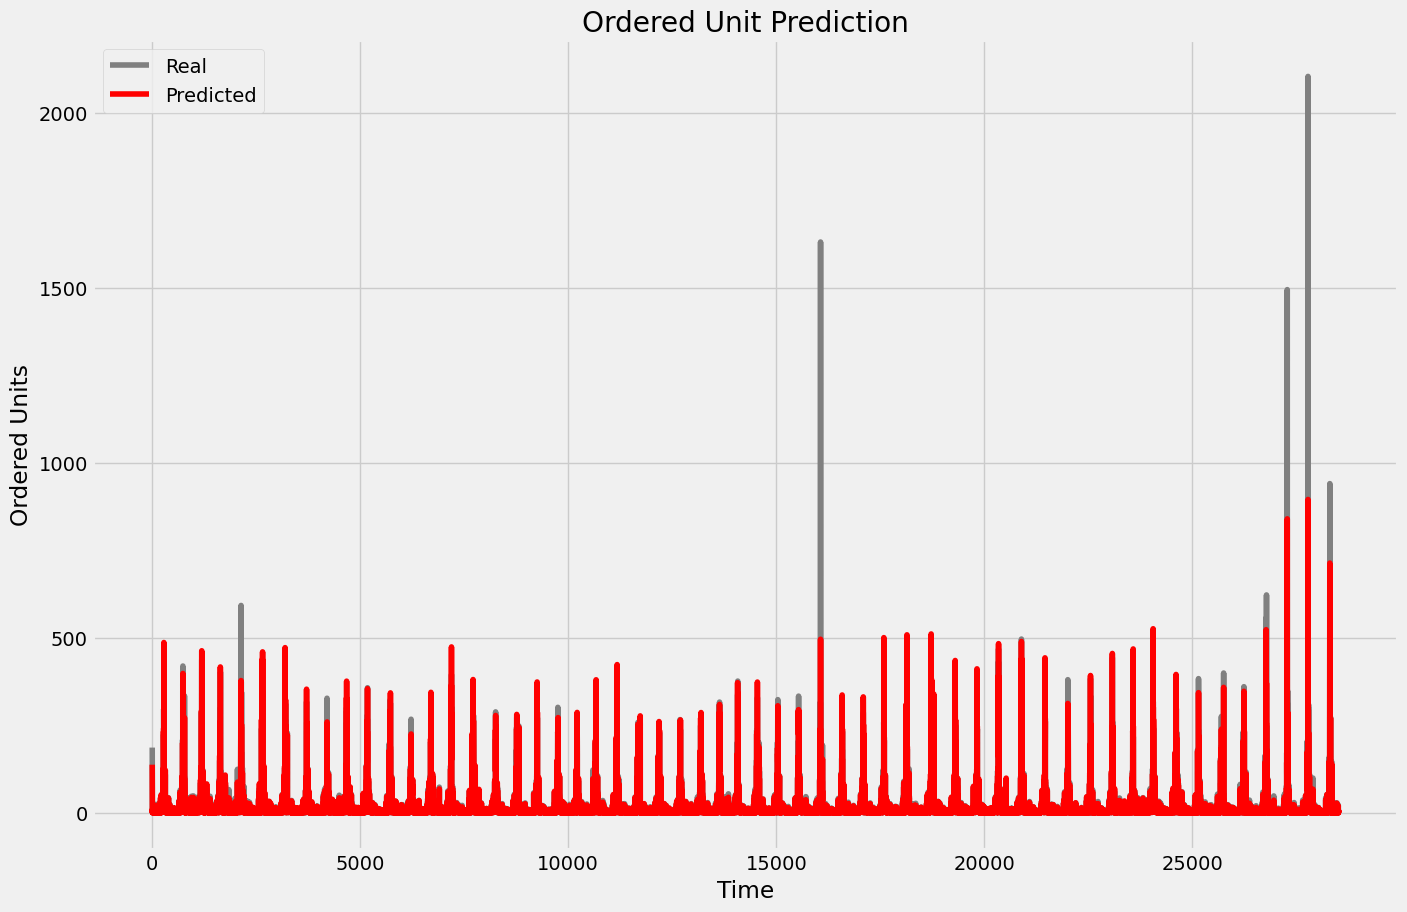

12.1358


In [75]:
lgb_pred_p = m_lgb_p.predict(transformed_test_df)
plot_predictions(ytest, lgb_pred_p)
print(my_rmse(ytest, lgb_pred_p))

In [76]:
nov_prediction = m_lgb_p.predict(transformed_nov_pred_df)
dec_prediction = m_lgb_p.predict(transformed_dec_pred_df)
jan_prediction = m_lgb_p.predict(transformed_jan_pred_df)

In [77]:
def plot(dataset):

    plt.figure(figsize=(15, 10))
    plt.plot(dataset, color="red", label="Predicted")
    plt.title("Ordered Unit Prediction")
    plt.xlabel("Time")
    plt.ylabel("Ordered Units")
    plt.show()
    

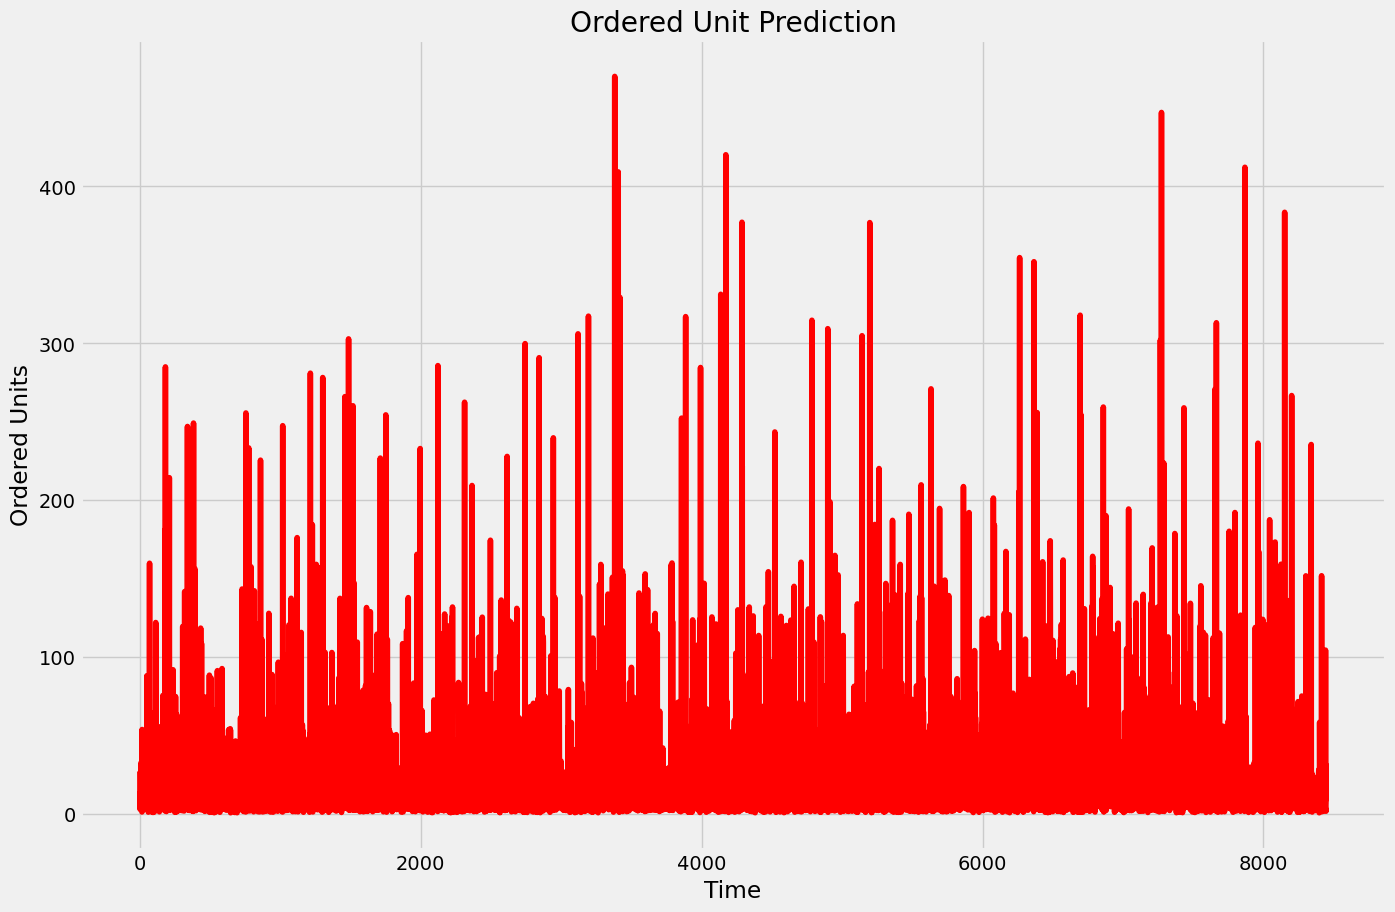

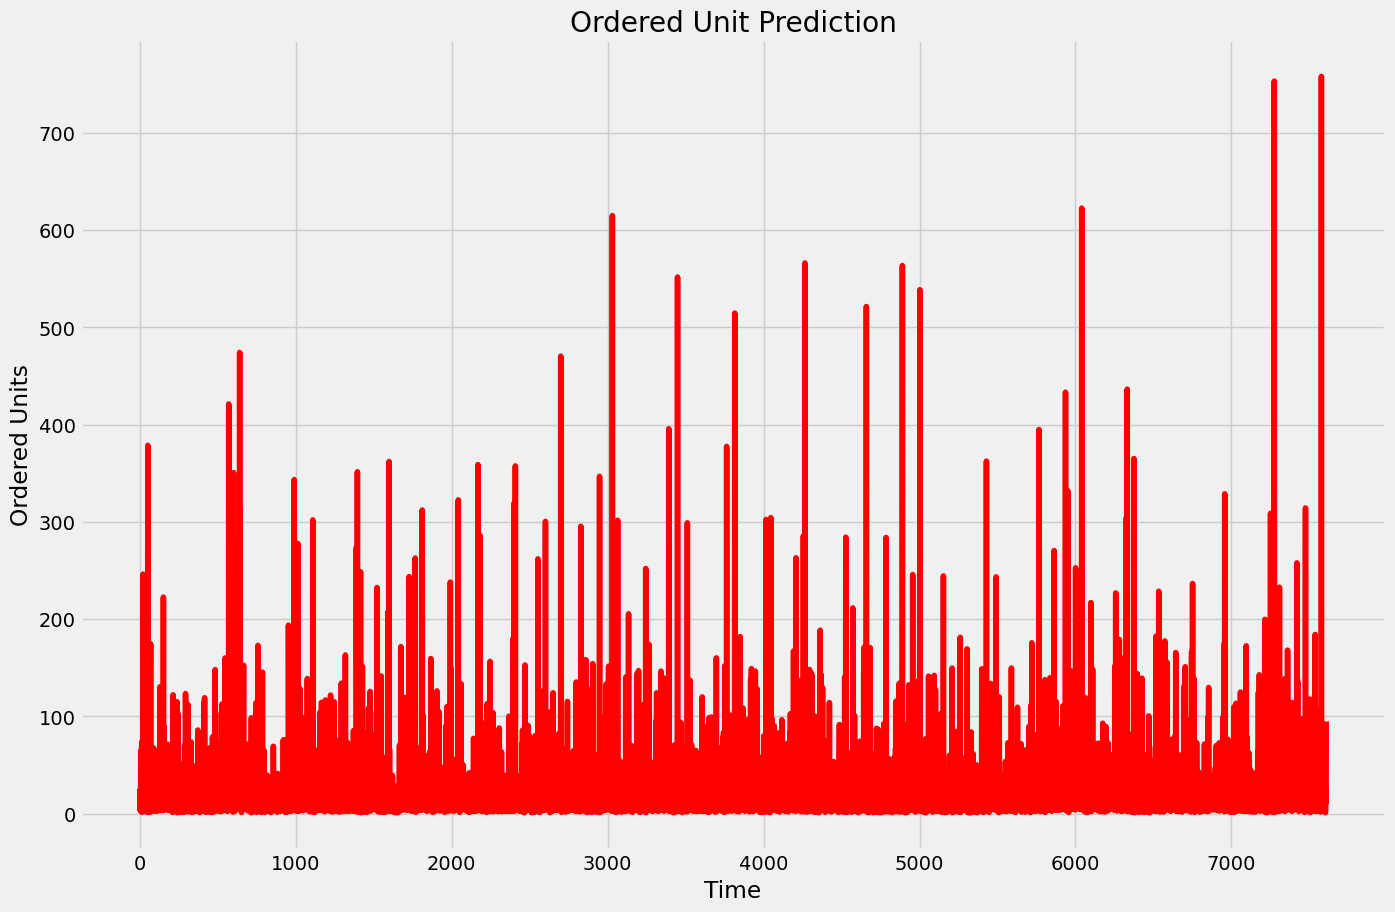

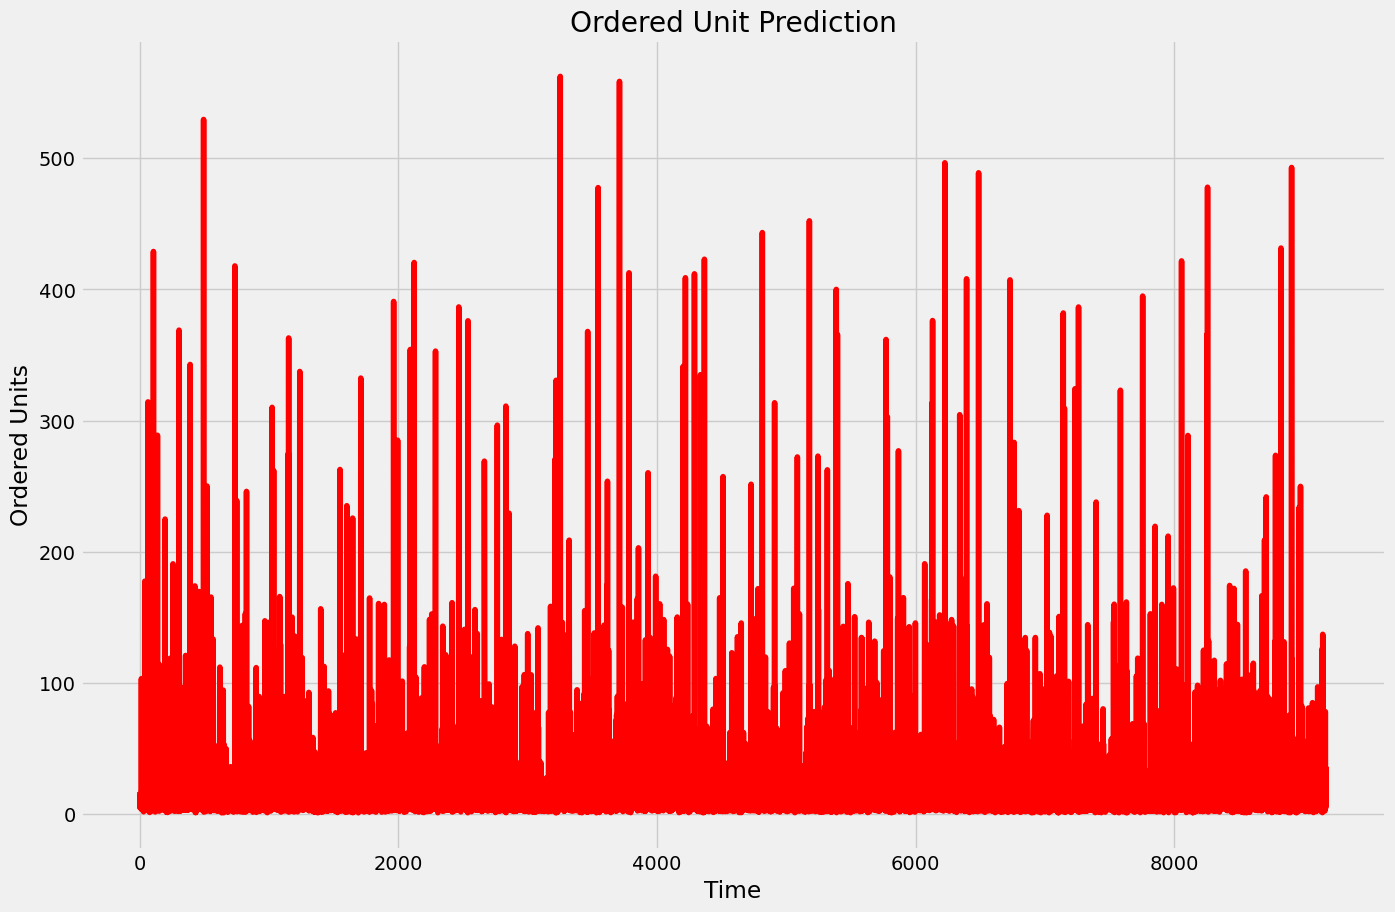

In [78]:
plot(nov_prediction)
plot(dec_prediction)
plot(jan_prediction)

In [79]:
transformed_nov_pred_df["Forecast"] = nov_prediction
transformed_dec_pred_df["Forecast"] = dec_prediction
transformed_jan_pred_df["Forecast"] = jan_prediction

In [80]:
# replacing certain column with another dataset 
def replace(dataset, column, new_dataset):
    dataset[column] = new_dataset[column]
    return dataset

In [81]:
nov_pred_df = replace(transformed_dec_pred_df, "ASIN", dec_pred_df)

In [82]:
transformed_nov_pred_df.to_excel("forecast_nov.xlsx")
transformed_dec_pred_df.to_excel("forecast_dec.xlsx")
transformed_jan_pred_df.to_excel("forecast_jan.xlsx")

## Using Optuna framework to fine tune the Lightgbm hyperparameter


In [83]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

In [84]:
def objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMRegressor(objective="poisson", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "rmse")
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test)
        cv_scores[idx] = my_rmse(y_test, preds)

    return np.mean(cv_scores)

In [85]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, transformed_train_df, ytrain)
study.optimize(func, n_trials=20)

[I 2023-05-20 15:56:06,321] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=4.205452383520787 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=7.612723414810739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.612723414810739
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0038697982808388685 will be ignored. Current value: lambda_l2=85
[1]	valid_0's rmse: 39.2235	valid_0's poisson: -31.829
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 38.734	valid_0's poisson: -32.762
[3]	valid_0's rmse: 38.288	valid_0's poisso

[W 2023-05-20 15:56:10,560] Trial 0 failed with parameters: {'learning_rate': 0.03289143384935078, 'num_leaves': 680, 'max_depth': 11, 'min_data_in_leaf': 3300, 'lambda_l1': 35, 'lambda_l2': 85, 'reg_alpha': 4.205452383520787, 'reg_lambda': 0.0038697982808388685, 'min_gain_to_split': 7.612723414810739, 'bagging_fraction': 0.30000000000000004, 'feature_fraction': 0.7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/joel/opt/anaconda3/envs/machinelearning/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/rb/rs1k3bnd1msfcnswgd49bmqc0000gn/T/ipykernel_2376/1220975762.py", line 2, in <lambda>
    func = lambda trial: objective(trial, transformed_train_df, ytrain)
  File "/var/folders/rb/rs1k3bnd1msfcnswgd49bmqc0000gn/T/ipykernel_2376/2562492162.py", line 28, in objective
    model.fit(
  File "/Users/joel/opt/anaconda3/envs/machinelearning/lib/python3.9

[37]	valid_0's rmse: 25.6557	valid_0's poisson: -44.2961
[38]	valid_0's rmse: 25.3418	valid_0's poisson: -44.4197
[39]	valid_0's rmse: 25.0317	valid_0's poisson: -44.5392
[40]	valid_0's rmse: 24.7397	valid_0's poisson: -44.6482
[41]	valid_0's rmse: 24.4407	valid_0's poisson: -44.7598
[42]	valid_0's rmse: 24.146	valid_0's poisson: -44.8677


KeyboardInterrupt: 

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
transformed_test_df